In [1]:
import spacy
from spacy import displacy
import json
from datetime import datetime
from spacy.tokens import DocBin, Doc, Span
from tqdm import tqdm
from spacy.util import filter_spans
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from collections import defaultdict
from spacy.training.example import Example

c:\Users\Bilal\.conda\envs\textMining\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Bilal\.conda\envs\textMining\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\Bilal\.conda\envs\textMining\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
with open(r"train.json", 'r') as f:
    data = json.load(f)

In [3]:
unique_ids = list(set([i['id'] for i in data]))

In [4]:
gt = []

In [5]:
for id in unique_ids:
    temp = []
    for i in data:
        if i['id'] == id:
            temp.append(i)
    temp_gt = temp[0]
    for i in temp:
        date = datetime.fromisoformat(i['updated_at'].strip('Z'))
        if date > datetime.fromisoformat(temp_gt['updated_at'].strip('Z')):
            temp_gt = i
    gt.append(temp_gt)

In [6]:
training_data = []
for example in gt:
    temp_dict = {}
    temp_dict['text'] = example['text']
    temp_dict['entities'] = []
    for annotation in example['label']:
        start = annotation['start']
        end = annotation['end']
        label = annotation['labels'][0]
        temp_dict['entities'].append((start, end, label))
    training_data.append(temp_dict)


In [10]:
def max_200(training_data):
    new_data = []
    for example in training_data:
        example_text = example['text']
        example_entities = example['entities']

        new_text = ' '.join(example_text.split()[:min([200, len(example_text.split())])])
        new_entities = [i for i in example_entities if i[1] <= len(new_text)]

        new_entrie = {'text':new_text, 'entities':new_entities}

        new_data.append(new_entrie)
    
    return new_data

In [8]:
training_data = max_200(training_data)

In [9]:
validation_data = training_data[int(len(training_data)*0.8):]
training_data = training_data[:int(len(training_data)*0.8)]

In [ ]:
nlp = spacy.blank("en")
doc_bin = DocBin()

In [ ]:
for training_example in tqdm(training_data):
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text)
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents
    doc_bin.add(doc)

doc_bin.to_disk("train.spacy")

In [ ]:
for training_example in tqdm(validation_data):
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text)
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents
    doc_bin.add(doc)

doc_bin.to_disk("val.spacy")

In [ ]:
!python -m spacy init fill-config base_config.cfg config.cfg

In [ ]:
!python -m spacy train config.cfg --output ./ --paths.train ./train.spacy --paths.dev ./val.spacy

In [2]:
nlp_ner = spacy.load("model-best")

c:\Users\Bilal\.conda\envs\textMining\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open(r"test.json", 'r') as f:
    data_test = json.load(f)

In [4]:
unique_ids_test = list(set([i['id'] for i in data_test]))

In [5]:
gt_test = []

In [6]:
for id in unique_ids_test:
    temp = []
    for i in data_test:
        if i['id'] == id:
            temp.append(i)
    temp_gt = temp[0]
    for i in temp:
        date = datetime.fromisoformat(i['updated_at'].strip('Z'))
        if date > datetime.fromisoformat(temp_gt['updated_at'].strip('Z')):
            temp_gt = i
    gt_test.append(temp_gt)

In [7]:
test_data = []
for example in gt_test:
    temp_dict = {}
    temp_dict['text'] = example['text']
    temp_dict['entities'] = []
    for annotation in example['label']:
        start = annotation['start']
        end = annotation['end']
        label = annotation['labels'][0]
        temp_dict['entities'].append((start, end, label))
    test_data.append(temp_dict)

In [11]:
test_data = max_200(test_data)

In [12]:
predictions = []

In [13]:
for example in test_data:
    doc = nlp_ner(example['text'])
    ner_results = {'text': example['text'], 'entities': []}
    for ent in doc.ents:
        ner_results['entities'].append((ent.start_char, 
                                        ent.end_char,
                                        ent.label_))
    predictions.append(ner_results)


In [93]:
def confusion_matrix_ner(labels:list, true:list, pred:list) -> np.ndarray:
    
    def extend_bounds(indices:tuple) -> list:

        extension = []
        modifications = [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (1,1), (-1,1), (1,-1), (0,0)]
        
        for mod in modifications:
            extension.append((indices[0]+mod[0], indices[1]+mod[1]))
        return extension

    cm = np.zeros((len(labels) + 1, len(labels) + 1))
    
    for (true_instance, pred_instance) in zip(true, pred):

        used_idx = []

        true_indices = [x[:2] for x in true_instance['entities']]
        pred_indices = [x[:2] for x in pred_instance['entities']]
        
        true_labels = [x[2] for x in true_instance['entities']]
        pred_labels = [x[2] for x in pred_instance['entities']]
 
        for i, idx_true in enumerate(true_indices):

            for j, idx_pred in enumerate(pred_indices):

                if idx_true in extend_bounds(idx_pred):
                    
                    if true_labels[i] == pred_labels[j]:
                        cm[labels.index(true_labels[i])][labels.index(true_labels[i])] += 1
                        used_idx.append(j)
                        break

                    else:
                        cm[labels.index(true_labels[i])][labels.index(pred_labels[j])] += 1
                        used_idx.append(j)
                        break

                else:
                    if j == len(pred_indices) - 1:
                        cm[labels.index(true_labels[i])][-1] += 1
                
                    else:
                        continue

        for i, idx_pred in enumerate(pred_indices):
            if i not in used_idx:
                cm[-1][labels.index(pred_labels[i])] += 1
        
    return cm

In [94]:
labels = ['REFERENCE','CLUB', 'COUNTRY', 'DATE', 'NATIONALITY', 'PLAYER', 'POSITION']

In [95]:
cm = confusion_matrix_ner(labels, test_data, predictions)

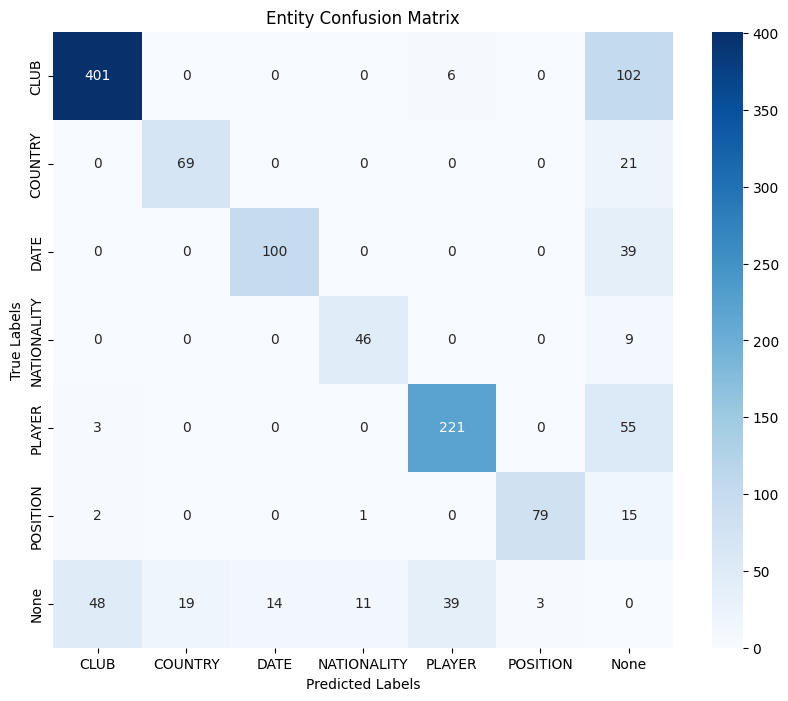

In [99]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm[1:,1:], fmt='.0f',annot=True, cmap="Blues", xticklabels=labels[1:]+['None'], yticklabels=labels[1:]+['None'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Entity Confusion Matrix")
plt.show()

In [ ]:
with open('predictions.json', 'w') as outp:
    json.dump(predictions, outp)

In [74]:
doc = nlp_ner(test_data[0]['text'])
spacy.displacy.render(doc, style='ent', jupyter=True)